In [1]:
# Common
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [2]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 100

# Model Name
MODEL_NAME = 'Handwritten-OCR'

# # Callbacks
# CALLBACKS = [
#     callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#     callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".keras", save_best_only=True)
# ]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = 'dataset/CSV/written_name_train.csv'
valid_csv_path = 'dataset/CSV/written_name_validation.csv'
test_csv_path = 'dataset/CSV/written_name_test.csv'

train_image_dir = 'dataset/train_v2/train'
valid_image_dir = 'dataset/validation_v2/validation'
test_image_dir = 'dataset/test_v2/test'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [3]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [4]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
train_csv.shape

(16000, 2)

In [6]:
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]

In [7]:
# Unique characters
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 41
Unique Characters : 
{'I', 'B', 'D', 'P', ' ', 'C', 'L', 'N', 'H', 'A', 'u', 'o', 'l', 'n', 't', 'r', 'T', 'M', 'e', "'", 'a', 'Z', 'F', 'c', 's', 'y', '-', 'G', 'J', 'E', 'p', 'W', 'K', 'X', 'S', 'Y', 'R', 'O', 'U', 'Q', 'V'}


In [8]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 24


In [9]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [10]:
train_csv.head()

,FILENAME,IDENTITY
0,dataset/train_v2/train/TRAIN_00001.jpg,BALTHAZAR
1,dataset/train_v2/train/TRAIN_00002.jpg,SIMON
2,dataset/train_v2/train/TRAIN_00003.jpg,BENES
3,dataset/train_v2/train/TRAIN_00004.jpg,LA LOVE
4,dataset/train_v2/train/TRAIN_00005.jpg,DAPHNE


In [11]:
valid_csv.head()

,FILENAME,IDENTITY
0,dataset/validation_v2/validation/VALIDATION_00...,BILEL
1,dataset/validation_v2/validation/VALIDATION_00...,LAUMIONIER
2,dataset/validation_v2/validation/VALIDATION_00...,LEA
3,dataset/validation_v2/validation/VALIDATION_00...,JEAN-ROCH
4,dataset/validation_v2/validation/VALIDATION_00...,RUPP


In [12]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None, 
    invert = True
)

In [13]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies 
    two processing functions: resizing and normalization. The processed image is then returned by 
    the function.
    
    Argument : 
        image_path : The path of the image file to be loaded.
    
    Return:
        image : The loaded image as a tensor.
    '''
    
    # Read the Image
    image = tf.io.read_file(image_path)
    
    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)
    
    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
    
    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))
    
    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])
    
    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)
    
    # Return loaded image
    return image

In [14]:
def encode_single_sample(image_path : str, label : str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    Arguments : 
        image_path : The location of the image file.
        label      : The text to present in the image.
    
    Returns:
        dict : A dictionary containing the processed image and label.
    '''
    
    # Get the image
    image = load_image(image_path)
    
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [15]:
import tensorflow as tf

# Convert columns to numpy arrays
filenames = np.array(train_csv['FILENAME'].to_list())
labels = np.array(train_csv['IDENTITY'].to_list())

# Create a dataset from the filenames and labels
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Shuffle the dataset
dataset = dataset.shuffle(1000)

# Map the encode function to the dataset
dataset = dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
dataset = dataset.batch(BATCH_SIZE)

# Prefetch to improve performance
train_ds = dataset.prefetch(tf.data.AUTOTUNE)


In [16]:
filenames = np.array(valid_csv['FILENAME'].to_list())
labels = np.array(valid_csv['IDENTITY'].to_list())

# Create a dataset from the filenames and labels
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Shuffle the dataset
dataset = dataset.shuffle(1000)

# Map the encode function to the dataset
dataset = dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
dataset = dataset.batch(BATCH_SIZE)

# Prefetch to improve performance
valid_ds = dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
filenames = np.array(test_csv['FILENAME'].to_list())
labels = np.array(test_csv['IDENTITY'].to_list())

# Create a dataset from the filenames and labels
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Shuffle the dataset
dataset = dataset.shuffle(1000)

# Map the encode function to the dataset
dataset = dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
dataset = dataset.batch(BATCH_SIZE)

# Prefetch to improve performance
test_ds = dataset.prefetch(tf.data.AUTOTUNE)

In [18]:
train_ds, valid_ds, test_ds

(<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>)

In [19]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 16000
Validation Data Size : 8000
Testing Data Size    : 1600


In [20]:
class CTCLayer(layers.Layer):
    
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        
        self.add_loss(loss)
        
        return y_pred

In [21]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model 
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [22]:
ocr_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 43)    │      5,547 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 43)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,563 (1.66 MB)

 Trainable params: 435,563 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=EPOCHS
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 181s 174ms/step - loss: 385.3569 - val_loss: 311.3774
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - loss: 307.8192 - val_loss: 299.5563
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - loss: 301.1735 - val_loss: 296.5020
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 123s 123ms/step - loss: 295.8876 - val_loss: 292.6903
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 121s 121ms/step - loss: 292.5300 - val_loss: 285.7276
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 121s 121ms/step - loss: 283.6946 - val_loss: 261.4280
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 120ms/step - loss: 261.0780 - val_loss: 239.9060
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - loss: 237.7795 - val_loss: 213.0862
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 127s 127ms/step - loss: 217.7156 - val_loss: 193.6945
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 122s 122ms/step - loss: 199.8504 - val_loss: 174.8200
Epoch 11/100
1000/1000 ━━━━━━

In [24]:
ocr_model.save('ocr_model.keras')

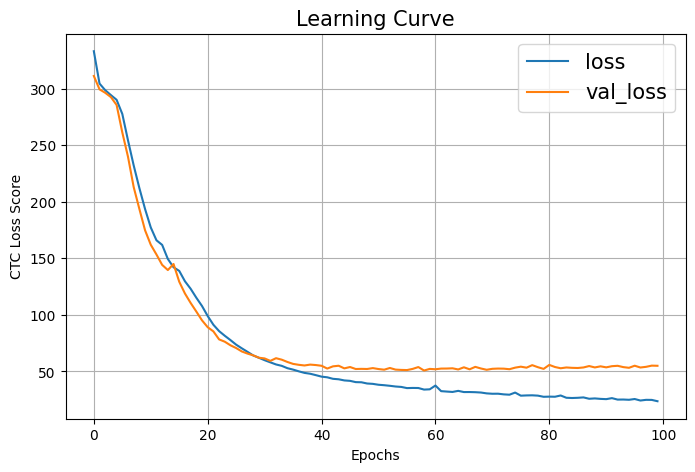

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve1.png")
plt.show()

In [33]:
# Model required for inference
inference_model = keras.Model(
    inputs=input_images,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 43)         │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,563 (1.66 MB)

 Trainable params: 435,563 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
def decode_pred(pred_label):
    
    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability 
    for each character. The function uses CTC decoding to decode the numeric labels back into their 
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.
    
    Argument : 
        pred_label : These are the model predictions which are needed to be decoded.
        
    Return:
        filtered_text : This is the list of all the decoded and processed predictions.
    
    '''
    
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [35]:
print(decode_pred(inference_model.predict(test_ds)))

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step
['LUZAS', 'THOMAS', 'BANDY', 'JORIS', 'DJENNANE', 'DEKBOM', 'DELBMARE', 'ROMAN', 'AMEL', 'LUNA', 'MARIE', 'JEANNE', 'BOULANGER', 'GLEURY', 'HAUDIQUERT', 'TOMAY', 'GRAPIN', 'DEYAUX', 'PALMADE', 'CASO', 'ANGELINA', 'FAUVAROUE', 'CLAIRE', 'SARA', 'ADERRRMAAN', 'OLIVIA', 'VICTORIA', 'ELPEGROUCK', 'PRIDAE', 'ALEAN', 'BOUCHIER', 'BEGUIN', 'YOUSSIE', 'THIRANT-FAUNOT', 'BORAIN', 'ARTHUE', 'NAHIZATA FATIN', 'CHEN', 'CEROI', 'ROMAN', 'LUCIE', 'DO', 'CHARLES', 'MARGOT', 'AYOUL', 'KIEL', 'MELANIE', 'SILHADDIN', 'ALEXIS', 'DICINT-O-ILLESCR', 'SOUCASSE', 'LEMIRE', 'JULIS CESAR', 'DORIEN', 'LORAS', 'HUE', 'LEO', 'PRIIEY', 'LISA', 'TILLEUL', 'YANN', 'LONA', 'MAHUL', 'CLARA', 'RHETAT', 'LAMDERGER', 'MASSON', 'DAVID', 'PAROCHE', 'MATHUS', 'EMMA', 'VALENTINE', 'SAMVEL', 'SOAUNE', 'MORYRA', 'FROMENT', 'CISSE', 'FLOREIN', 'FEURTE', 'NELIS', 'GOARIIN', 'KONY', 'INANI', 'CHEBHOURI', 'LANTIGNY', 'AMIRA', 'COM', 'COMPAIN', 'LISA', 'NOE', 'VICTOIRE-MARIE', 'CLAUERIE', '

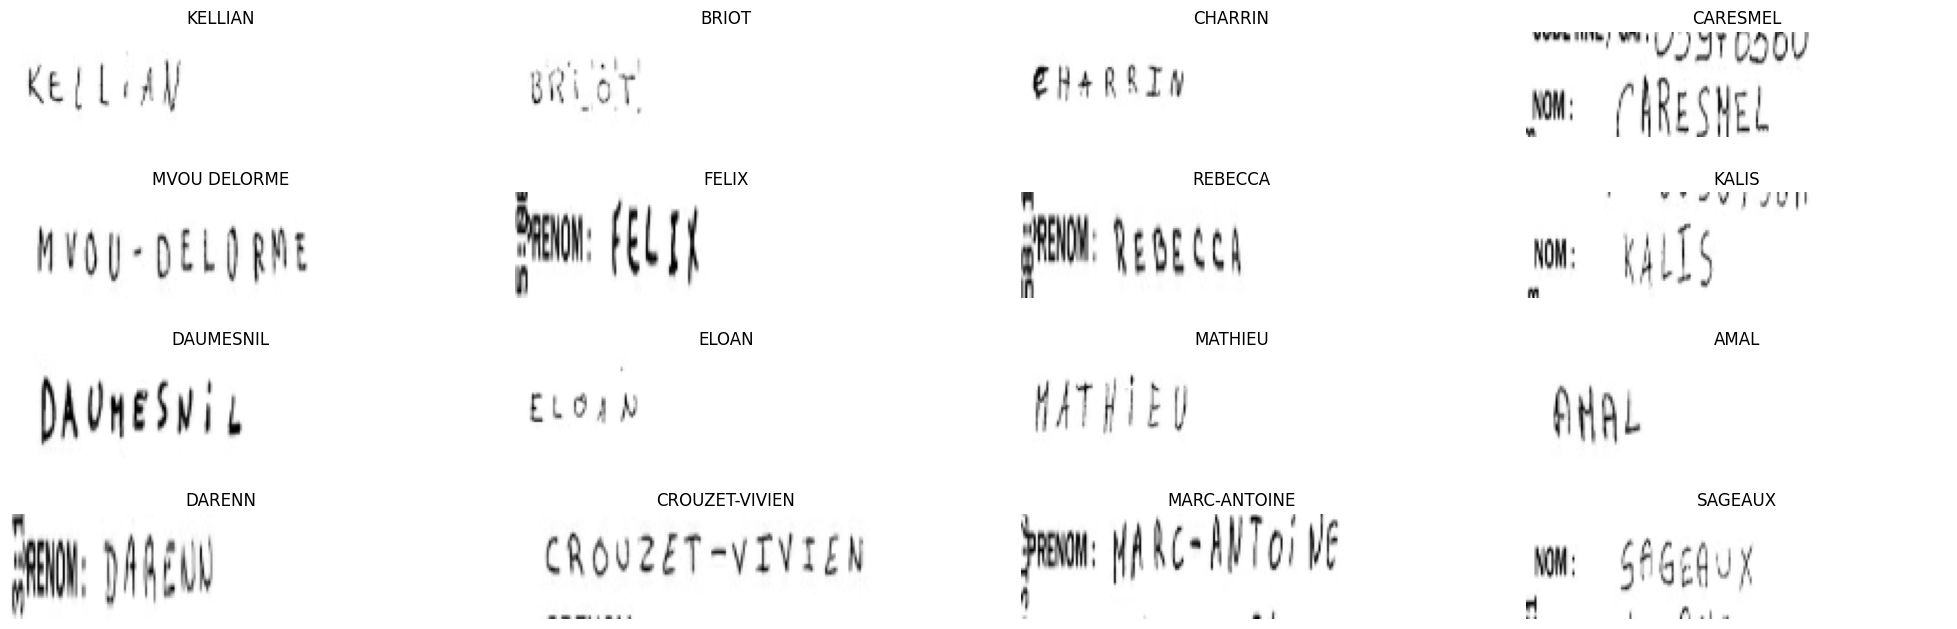

In [37]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()
    
show_images(data=train_ds, cmap='gray')


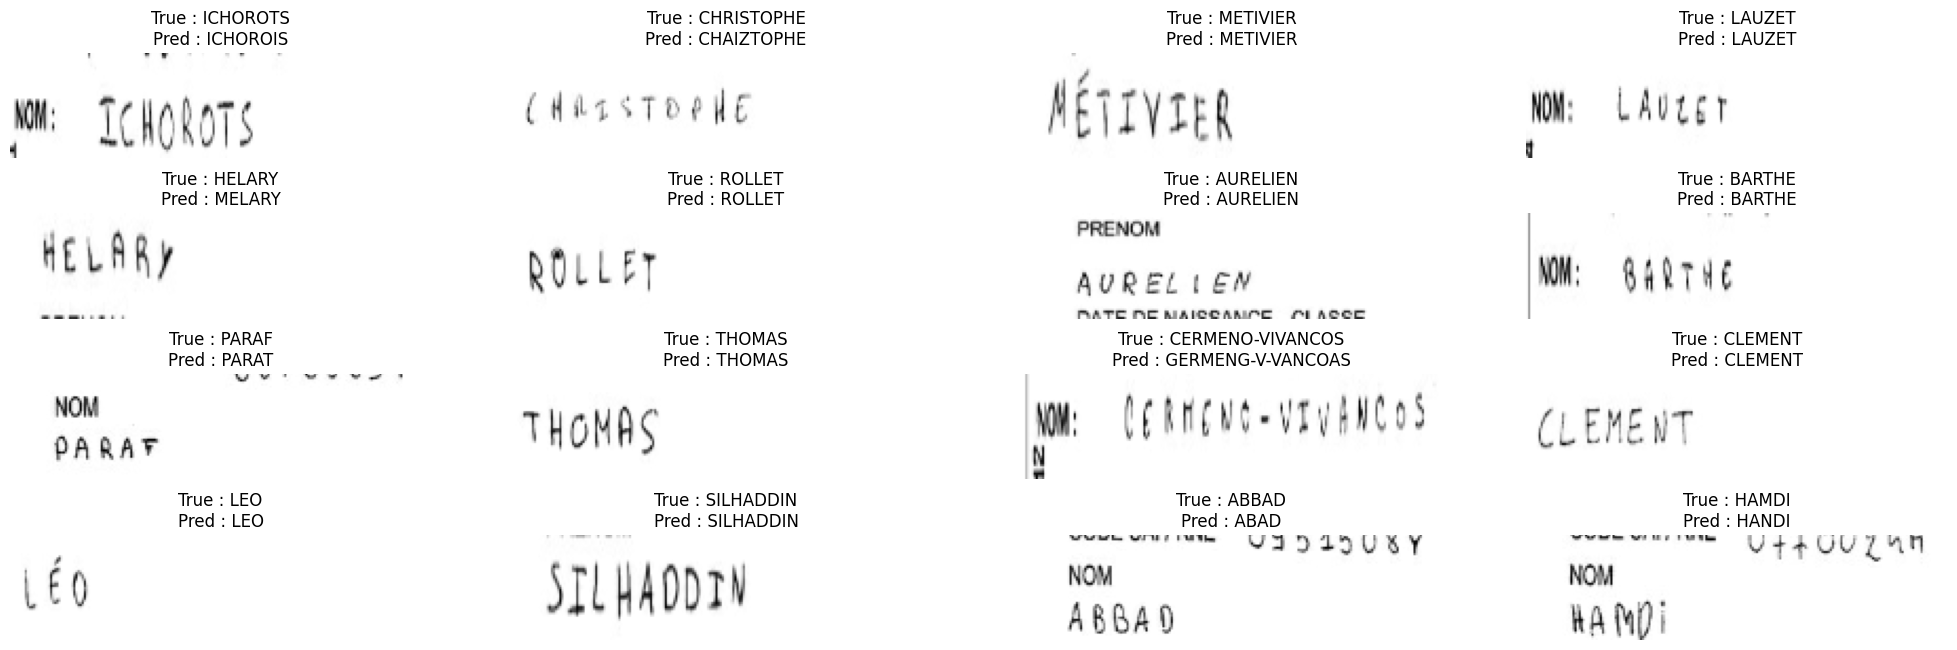

In [39]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='gray')

In [46]:
import numpy as np
from sklearn.metrics import accuracy_score

# Function to get predictions and decode them
def get_predictions_and_labels(model, data, decode_pred):
    predictions = []
    labels = []
    for batch in data:
        images = batch['image']
        lbls = batch['label']
        preds = model.predict(images)
        decoded_preds = [decode_pred(np.expand_dims(pred, axis=0))[0] for pred in preds]
        predictions.extend(decoded_preds)
        labels.extend(lbls.numpy())
    return predictions, labels

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(inference_model, test_ds, decode_pred)

# Decode true labels
true_labels = [tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8') for label in true_labels]

# Ensure predictions and true labels are in the same format
predictions = np.array(predictions).flatten()
true_labels = np.array(true_labels).flatten()

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Overall accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score

# Function to get predictions and decode them
def get_predictions_and_labels(model, data, decode_pred):
    predictions = []
    labels = []
    for batch in data:
        images = batch['image']
        lbls = batch['label']
        preds = model.predict(images)
        decoded_preds = [decode_pred(np.expand_dims(pred, axis=0))[0] for pred in preds]
        predictions.extend(decoded_preds)
        labels.extend(lbls.numpy())
    return predictions, labels

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(inference_model, test_ds, decode_pred)

# Decode true labels
true_labels = [tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8') for label in true_labels]

# Ensure predictions and true labels are in the same format
predictions = np.array(predictions).flatten()
true_labels = np.array(true_labels).flatten()

# Inspect a few predictions and their true labels
for i in range(10):
    print(f'Prediction: {predictions[i]}, True Label: {true_labels[i]}')

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Overall accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [48]:
import numpy as np
from sklearn.metrics import accuracy_score

# Function to get predictions and decode them
def get_predictions_and_labels(model, data, decode_pred):
    predictions = []
    labels = []
    for batch in data:
        images = batch['image']
        lbls = batch['label']
        preds = model.predict(images)
        decoded_preds = [decode_pred(np.expand_dims(pred, axis=0))[0] for pred in preds]
        predictions.extend(decoded_preds)
        labels.extend(lbls.numpy())
    return predictions, labels

# Function to clean labels by removing [UNK] tokens
def clean_label(label):
    return label.replace("[UNK]", "").strip()

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(inference_model, test_ds, decode_pred)

# Decode true labels and clean them
true_labels = [clean_label(tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8')) for label in true_labels]

# Ensure predictions and true labels are in the same format
predictions = np.array(predictions).flatten()
true_labels = np.array(true_labels).flatten()

# Inspect a few predictions and their true labels
for i in range(10):
    print(f'Prediction: {predictions[i]}, True Label: {true_labels[i]}')

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Overall accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [63]:
import numpy as np
import tensorflow as tf

# Assuming IMG_HEIGHT and IMG_WIDTH are defined
IMG_HEIGHT = 50
IMG_WIDTH = 200

# Function to preprocess the image
def load_image(image_path: str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies 
    two processing functions: resizing and normalization. The processed image is then returned by 
    the function.
    
    Argument : 
        image_path : The path of the image file to be loaded.
    
    Return:
        image : The loaded image as a tensor.
    '''
    # Read the Image
    image = tf.io.read_file(image_path)
    
    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    
    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    
    # Resize the image
    resized_image = tf.image.resize(images=cnvt_image, size=(IMG_HEIGHT, IMG_WIDTH))
    
    # Transpose
    image = tf.transpose(resized_image, perm=[1, 0, 2])
    
    # Convert image to a tensor.
    image = tf.cast(image, dtype=tf.float32)
    
    # Add batch dimension
    image = tf.expand_dims(image, axis=0)
    
    # Return loaded image
    return image

# Load the image
image_path = 'OCRModel-LearningCurve.png'  # Update this to the path of your image
image = load_image(image_path)

# Predict the content of the image
prediction = inference_model.predict(image)
print(f'Prediction: {prediction}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
Prediction: [[[1.6676449e-12 8.1161764e-03 4.7371858e-03 ... 1.9022689e-04
   2.7604403e-06 1.4505032e-02]
  [9.6956838e-15 2.0458435e-03 6.6606345e-04 ... 2.9667055e-07
   1.8392863e-04 1.7156023e-01]
  [5.2526525e-12 5.3796582e-03 6.5549975e-03 ... 2.3726029e-04
   2.2597341e-03 6.3706130e-01]
  ...
  [3.0804931e-16 2.0556741e-03 2.1733271e-07 ... 1.2228371e-09
   6.9085158e-06 9.9766672e-01]
  [2.1337673e-12 9.3668737e-03 1.5458310e-04 ... 2.4341110e-05
   3.3950360e-04 7.4832475e-01]
  [6.8880623e-11 1.2878123e-02 3.9504484e-05 ... 1.8931708e-04
   1.6671766e-03 9.3633644e-02]]]
